In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.autoencoder_v2 import *
from model.autoencoder_v2_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

In [2]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader)
inputs, lengths = next(small_data_iter)   

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v2"

model  = PatientAutoencoder(
    n_features=154, embedding_dim=128, n_heads=2, som_grid=(12,12)
).to(device)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
os.makedirs(stage1_dir, exist_ok=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model1,history1=train_phase1_som_only(model, train_loader, val_loader, device, optimizer,epochs=50,save_path=stage1_dir)

[Phase1][Epoch 0] train: 1.3148, val: 1.3147
[Phase1][Epoch 10] train: 1.3152, val: 1.3152
[Phase1][Epoch 20] train: 1.3153, val: 1.3152
 Early stopping triggered.


In [5]:
stage2_dir = os.path.join(base_dir, "stage2")
os.makedirs(stage2_dir, exist_ok=True)
model2,history2=train_phase2_som_decoder_with_val(model1, train_loader, train_loader, device, optimizer,
                                      epochs=50, save_path=stage2_dir)

[Phase2][Epoch 0] train: 1.3222, val: 0.0044
[Phase2][Epoch 10] train: 1.3173, val: 0.0019
[Phase2][Epoch 20] train: 1.3165, val: 0.0014
[Phase2][Epoch 30] train: 1.3166, val: 0.0012
[Phase2][Epoch 40] train: 1.3163, val: 0.0011
[Phase2][Epoch 49] train: 1.3165, val: 0.0010


In [6]:

stage3_dir = os.path.join(base_dir, "stage3")
os.makedirs(stage3_dir, exist_ok=True)

model3,history3=train_phase3_joint_no_classifier_with_val(model2, train_loader, val_loader, device, optimizer,epochs=100,save_path=stage3_dir)

[Phase3][Epoch 0] train: 1.3016, val: 0.0017
[Phase3][Epoch 10] train: 1.3042, val: 0.0009
[Phase3][Epoch 20] train: 1.3039, val: 0.0008
[Phase3][Epoch 30] train: 1.3045, val: 0.0008
[Phase3][Epoch 40] train: 1.3025, val: 0.0008
[Phase3][Epoch 50] train: 1.3038, val: 0.0007
[Phase3][Epoch 60] train: 1.3064, val: 0.0007
[Phase3][Epoch 70] train: 1.3075, val: 0.0006
[Phase3][Epoch 80] train: 1.3082, val: 0.0006
[Phase3][Epoch 90] train: 1.3086, val: 0.0005
[Phase3][Epoch 99] train: 1.3086, val: 0.0005


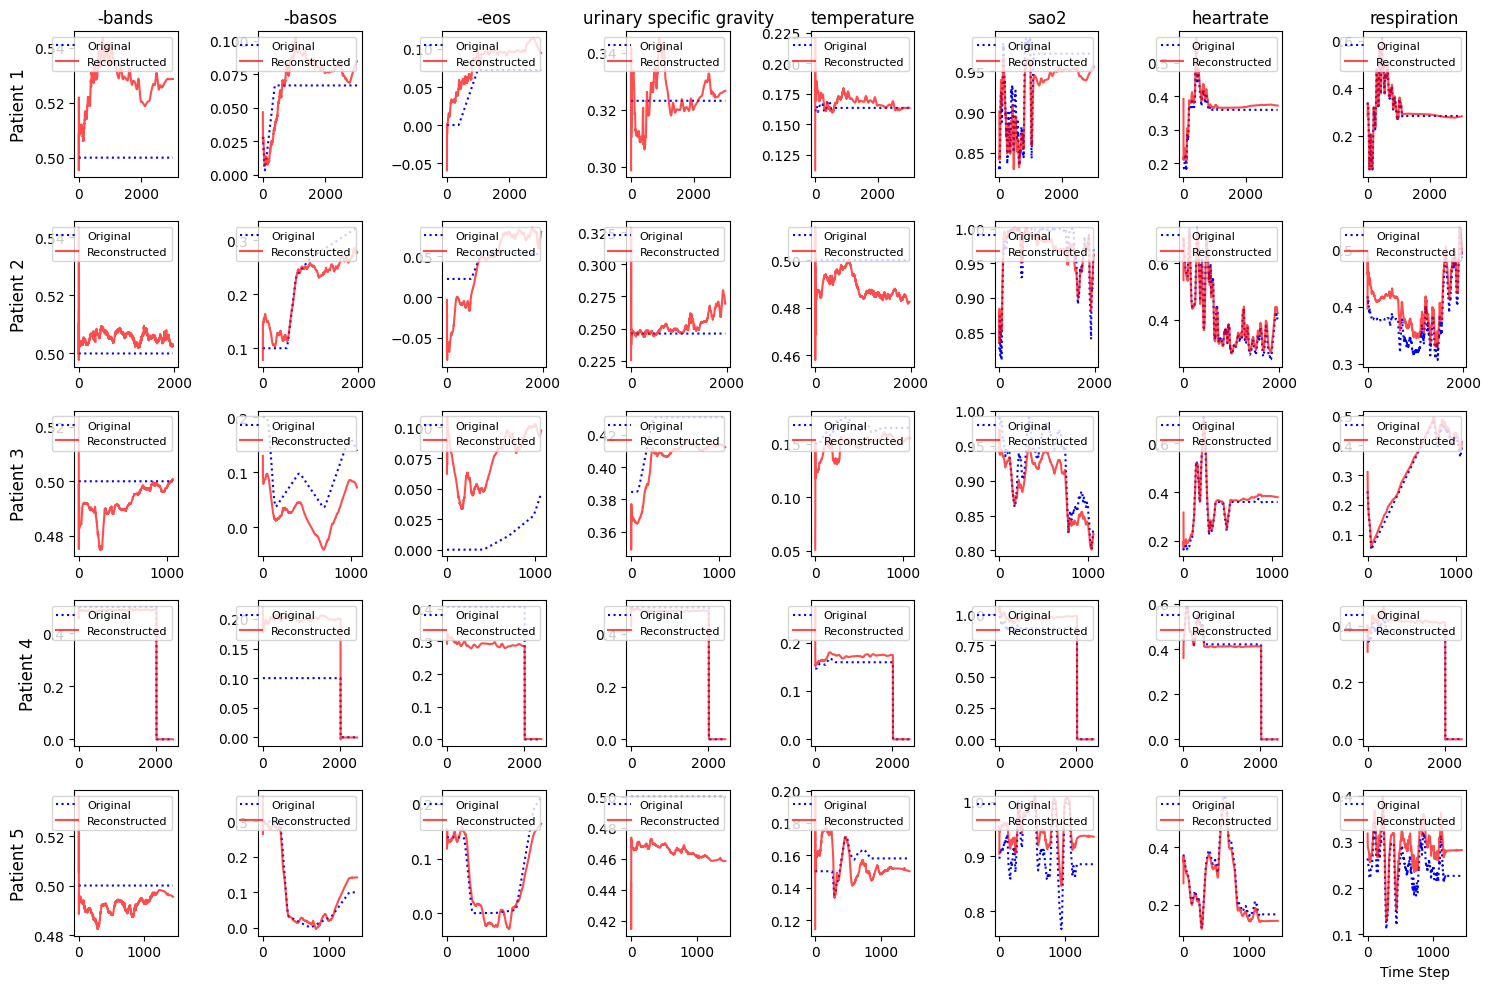

In [7]:
# stage3_cpt = os.path.join(base_dir, "stage3/joint_epoch090.pth")

# model.load_state_dict(torch.load(stage3_cpt, map_location=device,weights_only=True))


with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)

In [8]:
## load the best model

best_model_dir = os.path.join(base_dir, "stage3/best_model.pth")
model3.load_state_dict(torch.load(best_model_dir, map_location=device,weights_only=True))

<All keys matched successfully>